### **Predictive analytics to understand the drivers of customers who are recommending the products.**

**Import necessary Libraries**

In [3]:
import pandas as pd 
import re
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')
from wordcloud import WordCloud
import shap
# text pre processing nltk and spacy libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict

# scikit learn packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics  import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
# reproducibility 
np.random.seed(42)

**Read the data**

In [4]:
df = pd.read_excel("Womens Clothing Reviews Data.xlsx")

In [5]:
# clean the feature names for consistency 
df.columns= df.columns.str.replace(' ', '_')
# convert to lowercase 
df.columns = df.columns.str.lower()

**Select relevent data** 

In [42]:
review_data = df[['review_text', 'recommend_flag', 'rating']]

In [43]:
# drop duplicates and missing values 
review_data = review_data.drop_duplicates()
review_data.dropna(inplace=True)

In [44]:
review_data.head()

,review_text,recommend_flag,rating
0,Absolutely wonderful - silky and sexy and comf...,1,4
1,Love this dress! it's sooo pretty. i happene...,1,5
2,I had such high hopes for this dress and reall...,0,3
3,"I love, love, love this jumpsuit. it's fun, fl...",1,5
4,This shirt is very flattering to all due to th...,1,5


**Pre-Process the Text Data**

In [45]:
# expand contraction 
def expand_contractions(text, contractions_dict):
    # Split the input text into a list of words
    words = text.split()
    
    # Use a list comprehension to iterate over each word and replace it with its expanded form
    expanded_text = ' '.join(contractions_dict.get(word, word) for word in words)
    
    # Return the expanded text
    return expanded_text

In [46]:
custom_stops = ['dress', 'top', 'love', 'great', 'like', 'one', 'cute', 'could', 'would', 
                'doe', 'however', 'also',  'shirt', 'much','ordered', 'back',
                'feel', 'loved', 'love', 'really', 
                'bought', 'nice', 'yet','but', 'add', 'without', 'sometimes', 'looked', 'bit']

In [47]:
# create lemmatizer 
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    
    # convoert to lower case
    text = text.lower()
    
    # expland contractions 
    text = expand_contractions(text, contractions_dict)
    
    # remove non-alpha characters and numbers using regex 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # tokenize the text 
    tokens = word_tokenize(text)
    
    # lemmatization 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # remove single letters 
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english') + custom_stops)
    tokens = [token for token in tokens if token not in stop_words]
    
    # rejoin tokens to a string 
    processed_text = ' '.join(tokens)
    
    return processed_text
    


In [48]:
# apply text pre-processing. 
review_data['clean_text'] = review_data['review_text'].apply(preprocess_text)

In [49]:
# define feature and label 
X = review_data['clean_text']
Y = review_data['recommend_flag']
Y1 = review_data['rating']

**Check for  class Imbalance**

In [50]:
Y.value_counts(normalize=True).reset_index()

,recommend_flag,proportion
0,1,0.818857
1,0,0.181143


We notice class imbalance in the label. 

In [51]:
# split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size=0.3, random_state=42, stratify=Y)

### **Featurising the Text data**

In [52]:
# text feature extraction using TF-IDF
# create a tf-idf vectoriser object
tfidf = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.95)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [53]:
# CountVectorizer 
cv_featurizer = CountVectorizer(max_features=2000, decode_error='ignore', min_df=10, max_df=0.95)
X_train_cv = cv_featurizer.fit_transform(X_train)
X_test_cv = cv_featurizer.transform(X_test) 

In [54]:
X_train_tf.shape, X_test_tf.shape

((15843, 2000), (6791, 2000))

In [55]:
X_train_cv.shape,  X_test_cv.shape

((15843, 2000), (6791, 2000))

#### **Model Training**

**Count Vectorised**

Model: Logistic Regression
Accuracy: 0.8435
Precision: 0.9448
Recall: 0.8590
F1 Score: 0.8999
ROC-AUC Score: 0.8906


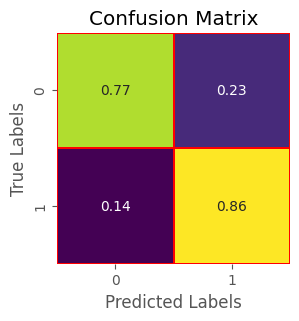

In [56]:
param_dict = {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
model_clf = LogisticRegression(class_weight='balanced', **param_dict)
model_clf.fit(X_train_cv, y_train)

y_pred = model_clf.predict(X_test_cv)
y_pred = model_clf.predict(X_test_cv)
y_pred_proba = model_clf.predict_proba(X_test_cv)[:, 1]  # Probability of positive class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics for each model
print(f"Model: Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='0.2f', 
            cmap="viridis", cbar=False,
            linewidths=0.3, linecolor='red',
            )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix')
plt.show()
print("===" * 30)

# Create a DataFrame to save evaluation metrics


**TF-IDF Vectorized**

Model: Logistic Regression
Accuracy: 0.8504
Precision: 0.9548
Recall: 0.8579
F1 Score: 0.9038
ROC-AUC Score: 0.9163


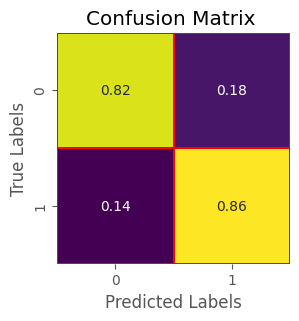

In [57]:
param_dict = {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
model_clf = LogisticRegression(class_weight='balanced', **param_dict)
model_clf.fit(X_train_tf, y_train)

y_pred = model_clf.predict(X_test_tf)
y_pred = model_clf.predict(X_test_tf)
y_pred_proba = model_clf.predict_proba(X_test_tf)[:, 1]  # Probability of positive class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics for each model
print(f"Model: Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='0.2f', 
            cmap="viridis", cbar=False,
            linewidths=0.3, linecolor='red',
            )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix ')
plt.show()
print("===" * 30)


##### **Important Driving features for product recommendation**:

**Using SHAP values**

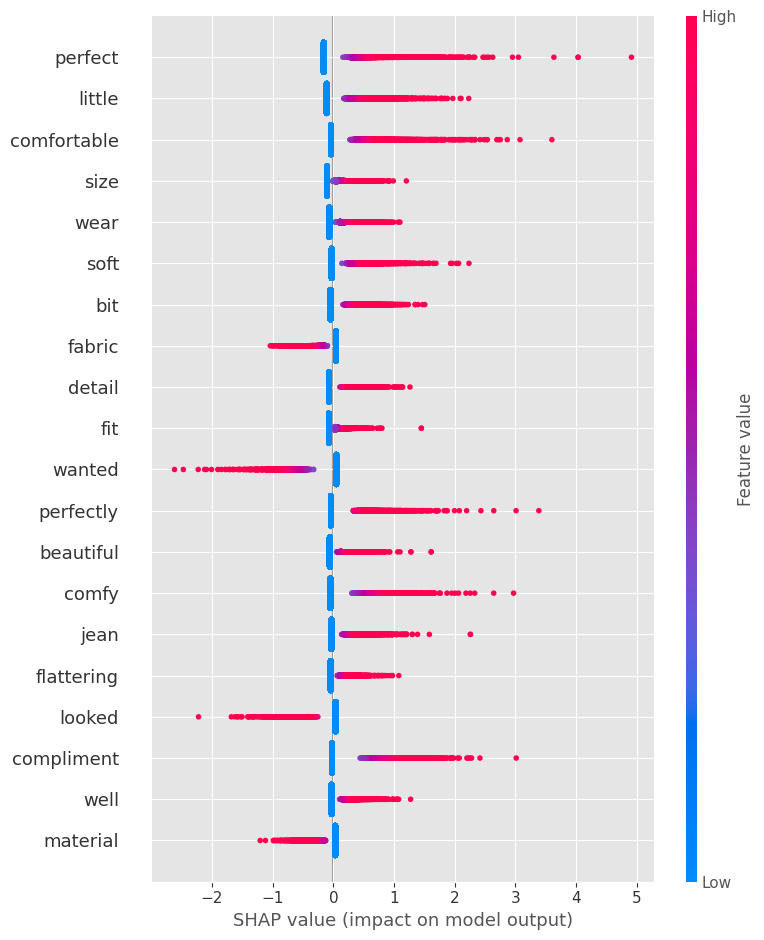

In [77]:
# Convert sparse matrix to dataframe for compatibility with SHAP
review_texts = pd.DataFrame(tfidf.transform(review_data['clean_text']).toarray(), columns=tfidf.get_feature_names_out())

# Create a SHAP explainer object for a logistic regression model
explainer = shap.Explainer(model_clf, review_texts)

# Calculate SHAP values for a set of instances (e.g., X_test_tf)
shap_values = explainer.shap_values(review_texts)

# Plot summary plot
shap.summary_plot(shap_values, review_texts)

# If you want to explain an individual prediction, you can use force_plot
# For example, explaining the first instance in the test set
# shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_tf[0, :].toarray(), feature_names=tfidf.get_feature_names_out())

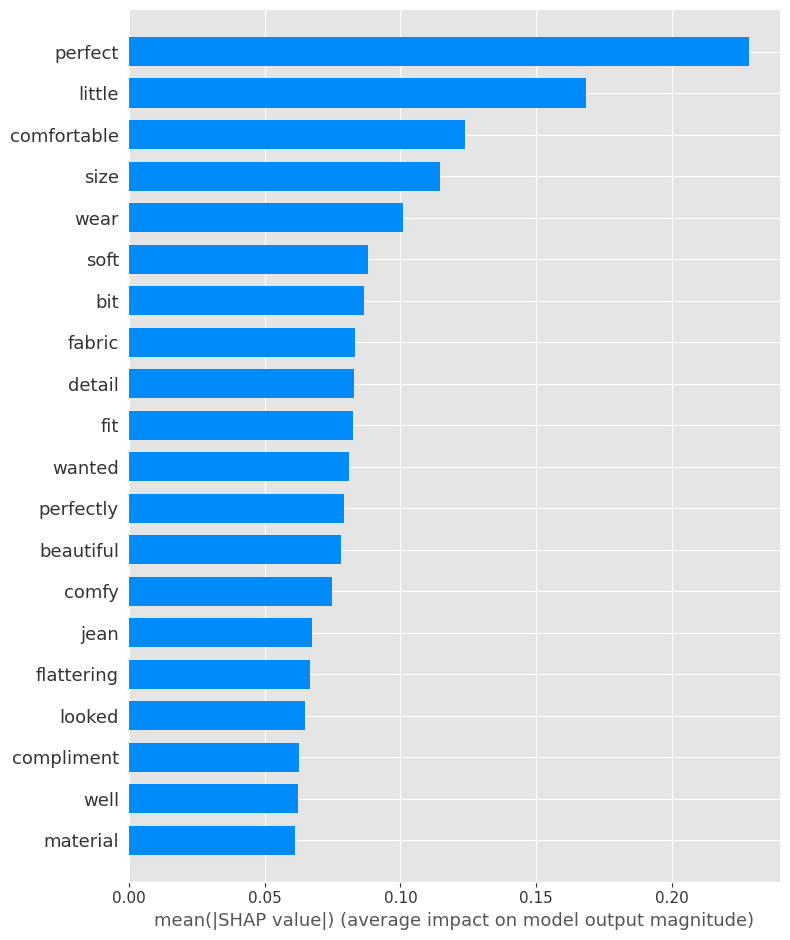

In [78]:
# Plot summary plot
shap.summary_plot(shap_values, review_texts, plot_type='bar')

**Word Cloud Representation**

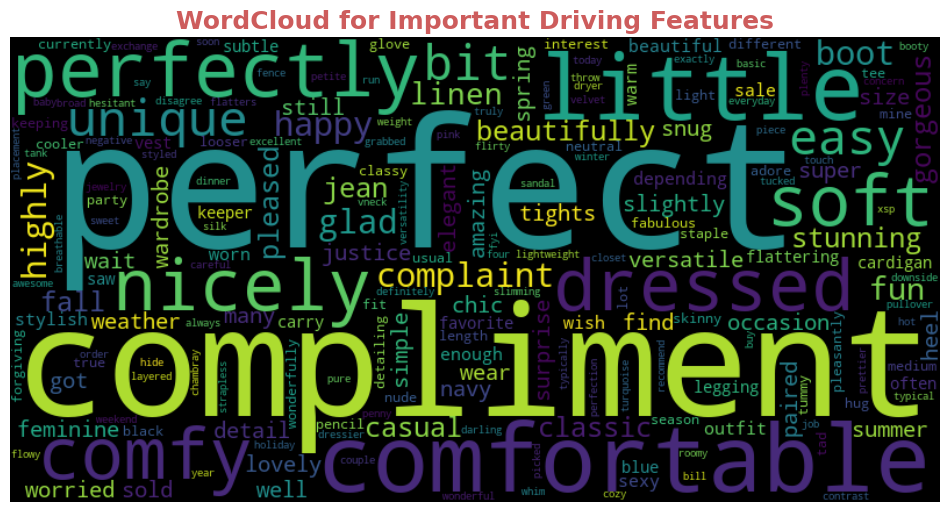

In [81]:
# extract feature names
feature_names = tfidf.get_feature_names_out() 
coefficients = model_clf.coef_[0]

# Map class indices to class labels
class_labels = ["Not Recommended", "Recommended"]

# Separate positive and negative coefficients
positive_coefficients = {word: coefficient for word, coefficient in zip(feature_names, coefficients) if coefficient > 0}

# Generate WordCloud for Positive Coefficients
wordcloud_positive = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(positive_coefficients)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title(f'WordCloud for Important Driving Features', weight='bold', color= 'indianred', fontsize=18)
plt.axis('off')
plt.show()



______________________________________________

## **Topic Modelling**

### **LDA Topic Modelling**

Import required Libraries 

In [1]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
# Define a function for text preprocessing

# custom stop words
custom_stops = [ 'love', 'great', 'like', 'one', 'cute', 'could', 'would', 
                'doe', 'however', 'also', 'much','back','wa'
               'loved', 'love', 'really', 'nice', 'yet','but', 'add', 'without', 'sometimes']
# function to preprocess the text data 
def preprocess_text(text):
    stop_words = set(stopwords.words('english') + custom_stops)
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

In [ ]:
# Apply text preprocessing to each review
review_data['processed_text'] = review_data['review_text'].apply(preprocess_text)

**Create a dictionary and a corpus**

In [35]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(review_data['processed_text'])

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in review_data['processed_text']]

**Train the LDA model**

In [36]:
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

**Evaluate the model** 

In [37]:
# Compute coherence score to evaluate the model
coherence_model = CoherenceModel(model=lda_model, texts=review_data['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.48141842549811054


**Visualize the topics**

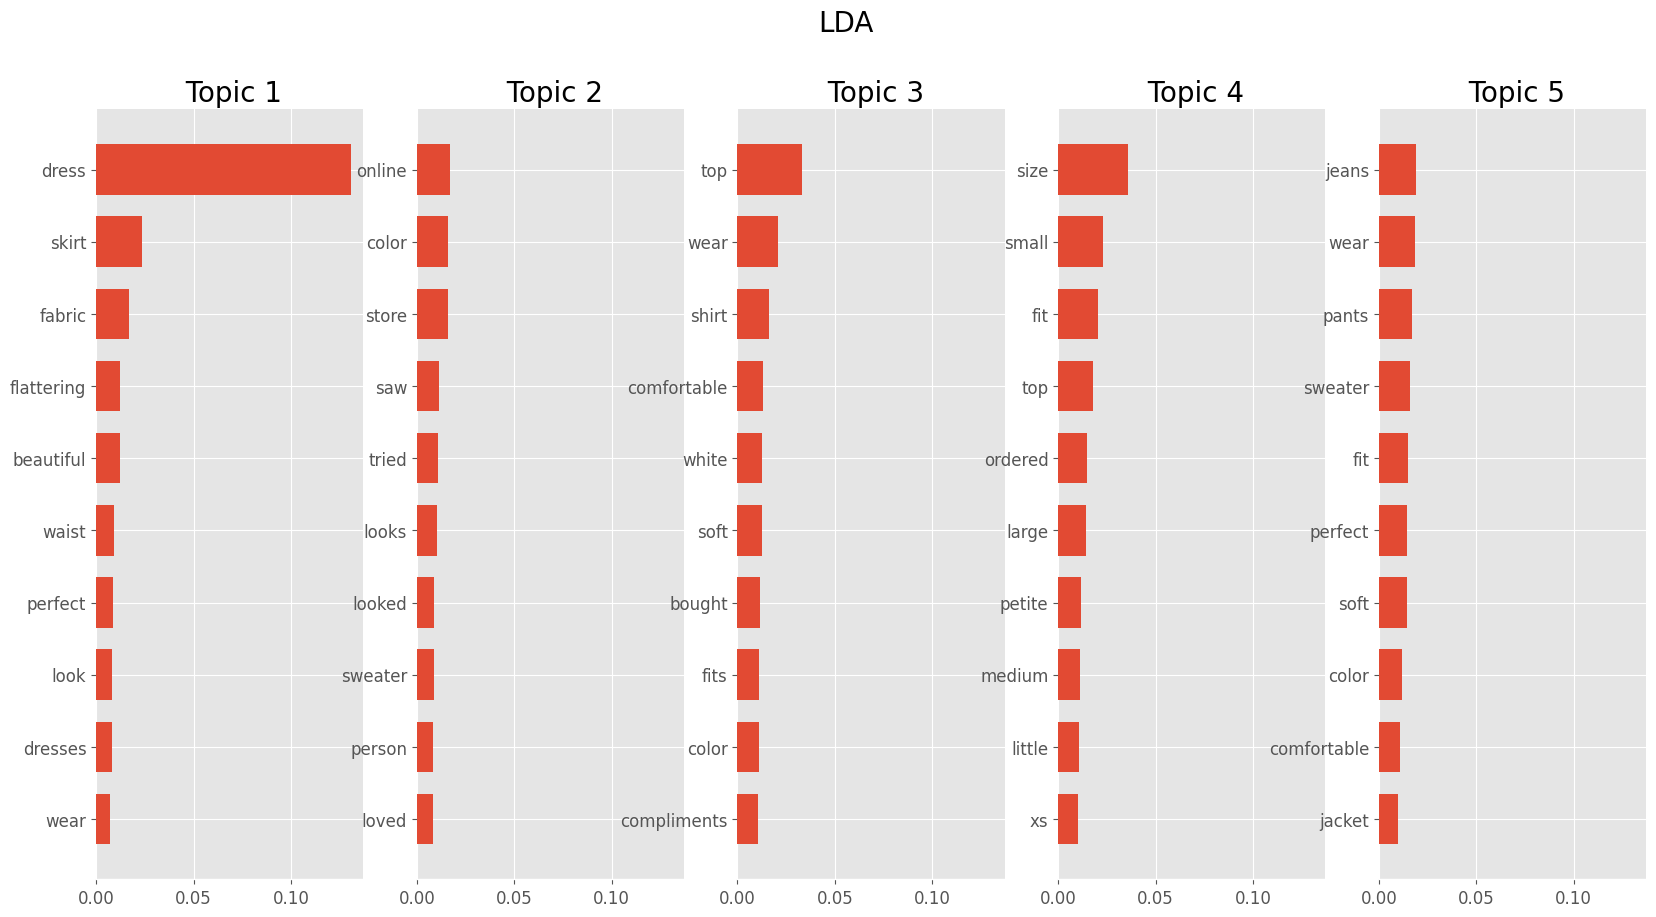

In [38]:
def plot_top_words(lda_model, feature_names, n_top_words=8):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    for topic_idx in range(lda_model.num_topics):
        topic = lda_model.show_topic(topic_idx, topn=n_top_words)
        top_features = [word for word, _ in topic]
        weights = [weight for _, weight in topic]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f" Topic {topic_idx + 1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle("LDA", fontsize=20)

# Assuming 'feature_names' is a list of words from your dictionary
feature_names = list(dictionary.token2id.keys())

# Call the function with your LDA model and feature names
plot_top_words(lda_model, feature_names, n_top_words=10)
plt.show()

C:\Users\aksha\AppData\Local\Temp\ipykernel_10020\2125420894.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['dominant_topic'] = dominant_topic


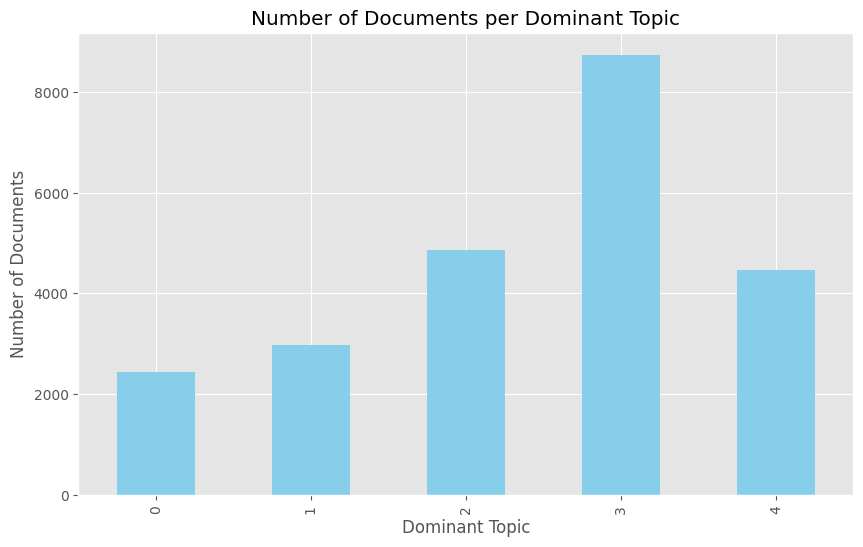

In [41]:
# Get topic distribution for each document
doc_topic_dist = lda_model.get_document_topics(corpus)

# Extract the dominant topic for each document
dominant_topic = [max(topic, key=lambda x: x[1])[0] for topic in doc_topic_dist]

# Add dominant topic information to the DataFrame
review_data['dominant_topic'] = dominant_topic

# Count the number of documents per dominant topic
topic_counts = review_data['dominant_topic'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Documents per Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.show()